# Yolov3 predict

# Package
- numpy = 1.15.2
- opencv-python =3.4.3
- tqdm = 4.27.0
- matplotlib = 2.2.3
- tensorflow = 1.10.0

# Import 所需檔案

In [1]:
import os

import argparse
import json
import cv2
from utils.utils import get_yolo_boxes, makedirs
from utils.bbox import draw_boxes
from keras.models import load_model
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from utils.colors import get_color

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Input data

In [12]:
#更改檔案input
# input_path   = 'retina.mp4'
input_path   = 'Predict/CNV-103044-4.jpeg'
labels = ['CNV', 'DME', 'DRUSEN']
# Load the model
infer_model = load_model('retina.h5')

# Predict

Predict/CNV-103044-4.jpeg


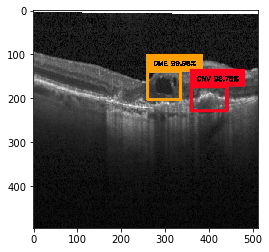

In [13]:
output_path  = 'output/'
makedirs(output_path)

# Set some parameter
net_h, net_w = 416, 416 # a multiple of 32, the smaller the faster
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [55,69, 75,234, 133,240, 136,129, 142,363, 203,290, 228,184, 285,359, 341,260]


# Predict bounding boxes 
if input_path[-4:] == '.mp4': # do detection on a video  
    video_out = output_path + input_path.split('/')[-1]
    video_reader = cv2.VideoCapture(input_path)

    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

    video_writer = cv2.VideoWriter(video_out,
                           cv2.VideoWriter_fourcc(*'MPEG'), 
                           24.0, 
                           (frame_w, frame_h))
    # the main loop
    batch_size  = 1
    images      = []
    start_point = 0 #%
    show_window = False
    status = 0
    mem = []
    for i in tqdm(range(nb_frames)):
        _, image = video_reader.read()
        if image is None:
            continue
        if (float(i+1)/nb_frames) > start_point/100.:
            images += [image]

            if (i%batch_size == 0) or (i == (nb_frames-1) and len(images) > 0):
                # predict the bounding boxes
                batch_boxes = get_yolo_boxes(infer_model, images, net_h, net_w, anchors, obj_thresh, nms_thresh)

                for i in range(len(images)):
                    # draw bounding boxes on the image using labels
                    draw_boxes(images[i], batch_boxes[i], labels, obj_thresh)   

                    # show the video with detection bounding boxes          
                    if show_window: cv2.imshow('video with bboxes', images[i])  

                    # write result to the output video
                    video_writer.write(images[i]) 
                images = []
            if show_window and cv2.waitKey(1) == 27: break  # esc to quit

    if show_window: cv2.destroyAllWindows()
    video_reader.release()
    video_writer.release()       
else: # do detection on an image or a set of images
    image_paths = []

    if os.path.isdir(input_path): 
        for inp_file in os.listdir(input_path):
            image_paths += [input_path + inp_file]
    else:
        image_paths += [input_path]

    image_paths = [inp_file for inp_file in image_paths if (inp_file[-4:] in ['.jpg', '.png', 'jpeg'])]

    # the main loop
    for image_path in image_paths:
        image = cv2.imread(image_path)
        print(image_path)

        # predict the bounding boxes
        boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, anchors, obj_thresh, nms_thresh)[0]

        # draw bounding boxes on the image using labels
        draw_boxes(image, boxes, labels, obj_thresh) 

        # write the image with bounding boxes to file
        output_img_path = output_path + image_path.split('/')[-1]
        cv2.imwrite(output_img_path, np.uint8(image))
        img = cv2.imread(output_img_path)[:,:,::-1]
        plt.imshow(img)
